In [1]:
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torchvision
import torch

import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
class ImageFolderWithFileName(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithFileName, self).__getitem__(index)
        # the image file path
        file_name = self.imgs[index][0].split('/')[-1]
        # make a new tuple that includes original and the path
        tuple_with_file_name = (original_tuple + (file_name,))
        return tuple_with_file_name

# CLASSIFICATION DATA LOADER

### Train Data Loader Medium
#### This dataloader return (img, label, filepath)

In [98]:
from torch.utils.data import Dataset
from torchvision import transforms, utils, datasets

val_test_data_transform = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                   std=[0.229, 0.224, 0.225])
                                             ])


validation_classification_dataset = datasets.ImageFolder(root='./data/validation_classification/medium', 
                                                                  transform=val_test_data_transform)

validation_classification_dataloader = torch.utils.data.DataLoader(validation_classification_dataset,
                                             batch_size=32,
                                             shuffle=True,
                                             num_workers=4)

In [93]:
train_data_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225])
                                          ])
train_medium_dataset = datasets.ImageFolder(root='./data/train_data/medium', 
                                            transform=train_data_transform)

train_medium_dataloader = torch.utils.data.DataLoader(train_medium_dataset,
                                             batch_size=32, 
                                             shuffle=True,
                                             num_workers=4)

# Visualize images in dataloader

# NN Architecture

### Baseline model
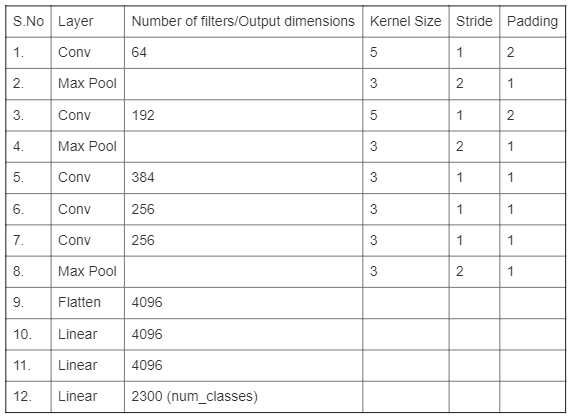

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
# torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
# CONV: Output size = (W-K+2P)/S + 1
# MAXPOOL: Output size = (W–K+2P)/S + 1.

class BaseLineNet(nn.Module):
    def __init__(self):
        super(BaseLineNet, self).__init__()
        self.batchsize = 32
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5,  stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace = True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=5,  stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(192)
        self.relu2 = nn.ReLU(inplace = True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=3,  stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.relu3 = nn.ReLU(inplace = True)
        
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3,  stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace = True)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,  stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.relu5 = nn.ReLU(inplace = True)
        
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(4096, 4096)
        self.fcbn1 = nn.BatchNorm1d(4096)
        self.relu6 = nn.ReLU(inplace = True)
        
        self.fc2 = nn.Linear(4096, 4096)
        self.fcbn2 = nn.BatchNorm1d(4096)
        self.relu7 = nn.ReLU(inplace = True)
        
        self.fc3 = nn.Linear(4096, 2300)

    def forward(self, x):
        # conv > bn > relu > pool > bn
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # conv > bn > relu > pool
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        
        # conv > bn > relu
        x = self.relu3(self.bn3(self.conv3(x)))
        
        # conv > bn > relu
        x = self.relu4(self.bn4(self.conv4(x)))
        
        # conv > bn > relu > pool
        x = self.pool5(self.relu5(self.bn5((self.conv5(x)))))
        
        # flatten
        x = x.view(-1, 4096)
        
        # fc > bn > relu
        x = F.relu(self.relu6(self.fc1(x)))
        
        # fc > bn > relu
        x = F.relu(self.relu7(self.fc2(x)))
        # may not need this group
        
        # fc
        x = self.fc3(x)
        return x

# RESNET

In [6]:
import os
import numpy as np
from PIL import Image

import torch
import torchvision   
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        
        # if there is down sample
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out

class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out


In [23]:
class ResNet(nn.Module):
 
    def __init__(self, block, layers, num_classes=2300, num_feat = 4096):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        
        self.linear_label = nn.Linear(512 * block.expansion, num_classes, bias=False)
        
        # For creating the embedding to be passed into the Center Loss criterion
        self.linear_closs = nn.Linear(512 * block.expansion, num_feat, bias=False)
        self.relu_closs = nn.ReLU(inplace=True)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        label_output = self.linear_label(x)
        label_output = label_output/torch.norm(self.linear_label.weight, dim=1)
        
        
        # Create the feature embedding for the Center Loss
        closs_output = self.linear_closs(x)
        closs_output = self.relu_closs(closs_output)

        return closs_output, label_output

In [24]:
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18']))
    return model

In [25]:
def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model

In [26]:
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

## Center Loss Function

In [100]:
class CenterLoss(nn.Module):
    """
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes, feat_dim, device=torch.device('cpu')):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.device = device
        
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).to(self.device))

    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long().to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = []
        for i in range(batch_size):
            value = distmat[i][mask[i]]
            value = value.clamp(min=1e-12, max=1e+12) # for numerical stability
            dist.append(value)
        dist = torch.cat(dist)
        loss = dist.mean()

        return loss

## RESNET - Center Loss - Train Function

In [120]:
def train_closs(model, data_loader, test_loader, task='Classification'):
    model.train()

    for epoch in range(numEpochs):
        avg_loss = 0.0
        for batch_num, data in enumerate(data_loader):
            feats, labels = data[0].to(device), data[1].to(device)
            
            optimizer_label.zero_grad()
            optimizer_closs.zero_grad()
            
            feature, outputs = model(feats)

            l_loss = criterion_label(outputs, labels.long())
#             c_loss = criterion_closs(feature, labels.long())
#             loss = l_loss + closs_weight * c_loss
            loss = l_loss
            loss.backward()
            
            optimizer_label.step()
#             # by doing so, weight_cent would not impact on the learning of centers
#             for param in criterion_closs.parameters():
#                 param.grad.data *= (1. / closs_weight)
            optimizer_closs.step()
            
            avg_loss += loss.item()

            if batch_num % 50 == 49:
                print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
                avg_loss = 0.0
                PATH = './resnet.pth'
                torch.save(model.state_dict(), PATH)
                # test
#                 if task == 'Classification':
#                     val_loss, val_acc = test_classify_closs(model, test_loader)
# #                     train_loss, train_acc = test_classify_closs(model, data_loader)
# #                     print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
# #                           format(train_loss, train_acc, val_loss, val_acc))
#                     print('Val Loss: {:.4f}\tVal Accuracy: {:.4f}'.format(val_loss, val_acc))
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        
        if task == 'Classification':
            val_loss, val_acc = test_classify_closs(model, test_loader)
            train_loss, train_acc = test_classify_closs(model, data_loader)
            print('Train Loss: {:.4f}\tTrain Accuracy: {:.4f}\tVal Loss: {:.4f}\tVal Accuracy: {:.4f}'.
                  format(train_loss, train_acc, val_loss, val_acc))
        else:
            test_verify(model, test_loader)




In [121]:
def test_classify_closs(model, test_loader):
    model.eval()
    test_loss = []
    accuracy = 0
    total = 0

    for batch_num, data in enumerate(test_loader):
        feats, labels = data[0].to(device), data[1].to(device)
        feature, outputs = model(feats)
        
        _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
        pred_labels = pred_labels.view(-1)
        
        l_loss = criterion_label(outputs, labels.long())
        #c_loss = criterion_closs(feature, labels.long())
        #loss = l_loss + closs_weight * c_loss
        loss=l_loss
        accuracy += torch.sum(torch.eq(pred_labels, labels)).item()
        total += len(labels)
        test_loss.extend([loss.item()]*feats.size()[0])
        del feats
        del labels

    model.train()
    return np.mean(test_loss), accuracy/total

In [122]:
numEpochs = 10
num_feats = 3

learningRate = 1e-2
weightDecay = 5e-5

num_classes = len(train_medium_dataset.classes)
print("num_classes = ", num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

closs_weight = 1
lr_cent = 0.5
feat_dim = 10

network = resnet18()
# network.load_state_dict(torch.load('./resnet_2hidden.pth'))
# network.apply(init_weights)

criterion_label = nn.CrossEntropyLoss()
#criterion_closs = CenterLoss(num_classes, feat_dim, device)
optimizer_label = torch.optim.SGD(network.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)
#optimizer_closs = torch.optim.SGD(criterion_closs.parameters(), lr=lr_cent)

num_classes =  2300


In [123]:
network.train()
network.to(device)
train_closs(network, train_medium_dataloader, validation_classification_dataloader)

Epoch: 1	Batch: 50	Avg-Loss: 8.3198
Epoch: 1	Batch: 100	Avg-Loss: 8.1797
Epoch: 1	Batch: 150	Avg-Loss: 7.9238
Epoch: 1	Batch: 200	Avg-Loss: 7.8142
Epoch: 1	Batch: 250	Avg-Loss: 7.7764
Epoch: 1	Batch: 300	Avg-Loss: 7.7676
Epoch: 1	Batch: 350	Avg-Loss: 7.7535
Epoch: 1	Batch: 400	Avg-Loss: 7.7416
Epoch: 1	Batch: 450	Avg-Loss: 7.7336
Epoch: 1	Batch: 500	Avg-Loss: 7.7435
Epoch: 1	Batch: 550	Avg-Loss: 7.7220
Epoch: 1	Batch: 600	Avg-Loss: 7.7221
Epoch: 1	Batch: 650	Avg-Loss: 7.7122
Epoch: 1	Batch: 700	Avg-Loss: 7.6960
Epoch: 1	Batch: 750	Avg-Loss: 7.7019
Epoch: 1	Batch: 800	Avg-Loss: 7.6990
Epoch: 1	Batch: 850	Avg-Loss: 7.6941
Epoch: 1	Batch: 900	Avg-Loss: 7.6853
Epoch: 1	Batch: 950	Avg-Loss: 7.6859
Epoch: 1	Batch: 1000	Avg-Loss: 7.6746
Epoch: 1	Batch: 1050	Avg-Loss: 7.6886
Epoch: 1	Batch: 1100	Avg-Loss: 7.6747
Epoch: 1	Batch: 1150	Avg-Loss: 7.6449
Epoch: 1	Batch: 1200	Avg-Loss: 7.6616
Epoch: 1	Batch: 1250	Avg-Loss: 7.6738
Epoch: 1	Batch: 1300	Avg-Loss: 7.6582
Epoch: 1	Batch: 1350	Avg-Loss: 7

KeyboardInterrupt: 

In [128]:
network = resnet18()
network.load_state_dict(torch.load('./resnet.pth'))
network.to(device)
val_loss, val_acc = test_classify_closs(network, validation_classification_dataloader)
print('Val Loss: {:.4f}\tVal Accuracy: {:.4f}'.
      format(val_loss, val_acc))

Val Loss: 6.4249	Val Accuracy: 0.0233


# LOSS Function and Optimizer
1. Trained using SGD with lr=0.01 with Nesterov momentum = 0.9 and weight decay = 5e-4 with a batch size = 256
2. StepLR scheduler with learning rate decayed by a multiplicative factor of gamma = 0.9 after every epoc

# Set GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [ ]:
import torch
loss = torch.nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
# 3*5
# sample number * embeded face
print(input)
target = torch.empty(3, dtype=torch.long).random_(5)
# 3
# sample number (label in it)
print(target)
output = loss(input, target)

# Training Loop

In [94]:
import torch.optim as optim

epoch_num = 10
print_interval = 100
net = BaseLineNet()
net.to(device)
net.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
# optimizer = optim.Adam(net.parameters(), lr=0.01)
# net.load_state_dict(torch.load('./baseline_bn.pth'))


for epoch in range(epoch_num):# loop over the dataset multiple times
    scheduler.step()
    running_loss = 0.0
    correct, total = 0, 0
    for i, data in enumerate(train_medium_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

        # print statistics
        running_loss += loss.item()
        if i % print_interval == 1:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / i))
            print('Accuracy of the network : %.8f %%' % (100 * correct / total))
            
            PATH = './baseline_bn.pth'
            torch.save(net.state_dict(), PATH)

print('Finished Training')

ValueError: Expected input batch_size (1568) to match target batch_size (32).

# Classification Validation

### Load the model

In [95]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = BaseLineNet()
net.load_state_dict(torch.load('./baseline_bn1.pth'))
net.to(device)


correct = 0
total = 0
with torch.no_grad():
    for data in validation_classification_dataloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print()
print(correct, total)
print("Accuracy of the network on the test images: {0}".format(100 * correct / total))

cuda:0


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/datasets/folder.py", line 140, in __getitem__
    sample = self.transform(sample)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 70, in __call__
    img = t(img)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/transforms/transforms.py", line 207, in __call__
    return F.resize(img, self.size, self.interpolation)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torchvision/transforms/functional.py", line 238, in resize
    raise TypeError('img should be PIL Image. Got {}'.format(type(img)))
TypeError: img should be PIL Image. Got <class 'torch.Tensor'>


## Test and IO for classification

In [ ]:
# test_classification_dataset = datasets.ImageFolder(root='./data/test_classification', 
#                                                    transform=val_test_data_transform)
test_classification_dataset = ImageFolderWithFileName(root='./data/test_classification', 
                                                   transform=val_test_data_transform)
test_classification_dataloader = torch.utils.data.DataLoader(test_classification_dataset,
                                             batch_size=256, 
                                             shuffle=False,
                                             num_workers=4)

net = BaseLineNet()
net.to(device)

net.load_state_dict(torch.load('./baseline_bn1.pth'))

In [ ]:
import pandas as pd
import os
from pandas.core.frame import DataFrame

a = range(2300)
b = [str(i) for i in a]
b.sort()
idx_to_class = dict(zip(a,b))

i = 0
with torch.no_grad():
    for i, data in enumerate(test_classification_dataloader):
        images, labels, file_name = data[0].to(device), data[1].to(device), data[2]
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        
        predicted_class = []
        for j, idx in enumerate(predicted):
            predicted_class.append(idx_to_class[idx.item()])

        dict_data = {'Id': list(file_name), 'Category': predicted_class}
        df_ = DataFrame(dict_data)
        if i == 0:
            df = df_
        else:
            df = pd.concat([df, df_])
        
df.to_csv('out_classification.csv', index=False)

### IO for verification
#### Store the path of two image and the label in three lists

In [ ]:
import pandas as pd
import os

def verification_pipeline(file_path, file_root, validation=True):
    if validation:
        df = pd.read_csv(file_path, sep=' ', header=None, names=['image1', 'image2', 'result'])
    else:
        df = pd.read_csv(file_path, sep=' ', header=None, names=['image1', 'image2'])
    df['image1'] = file_root + df['image1']
    df['image2'] = file_root + df['image2']
    image_1 = df['image1'].tolist()
    image_2 = df['image2'].tolist()
    if validation:
        is_same = df['result'].tolist()
    else:
        is_same = [-1] * df.shape[0]
    return image_1, image_2, is_same


vv_file_path = './data/validation_trials_verification.txt'
tv_file_path = './data/test_trials_verification_student.txt'
vv_root_path = "./data/validation_verification/"
tv_root_path = "./data/test_verification/"

vv_image_one, vv_image_two, vv_issame = verification_pipeline(vv_file_path, vv_root_path, True)
tv_image_one, tv_image_two, tv_issame = verification_pipeline(tv_file_path, tv_root_path, validation=False)

In [ ]:
print(vv_image_one[100])
print(vv_image_two[100])
print(vv_issame[100])

print(tv_image_one[100])
print(tv_image_two[100])
print(tv_issame[100])

### Customized dataloader return two imgs and a bool lable for verification

In [ ]:
from PIL import Image
class Verification_dataset(Dataset):#need to inherit data.Dataset
    
    def __init__(self, image_one, image_two, is_same_person, transform=None):

        self.image_one_list = image_one
        self.image_two_list = image_two
        self.is_same_person_list = is_same_person

        self.toTensor = transforms.ToTensor()
        self.transform = transform

    
    def __getitem__(self, i):
        im1 = Image.open(self.image_one_list[i])
        if self.transform is not None:
            im1 = self.transform(im1)
        
        im2 = Image.open(self.image_two_list[i])
        if self.transform is not None:
            im2 = self.transform(im2)
        
        issame = self.is_same_person_list[i]

        return im1, im2, issame
 
    def __len__(self):
        return len(self.image_one_list)

In [ ]:
from PIL import Image
class CompareDataset(Dataset):
    """Custom Dataset for loading compare face images"""

    def __init__(self, txt_path, img_dir, transform=None):
    
        df = pd.read_csv(txt_path, sep=" ", header=None, names=['img1', 'img2'])
        self.img_dir = img_dir
        self.txt_path = txt_path
        self.img1_names = df['img1'].index.values
        self.img2_names = df['img2'].index.values
        self.transform = transform

    def __getitem__(self, index):
        img1 = Image.open(os.path.join(self.img_dir,
                                       self.img1_names[index]))
        
        if self.transform is not None:
            img1 = self.transform(img1)
        
        img2 = Image.open(os.path.join(self.img_dir,
                                       self.img2_names[index]))
        
        if self.transform is not None:
            img2 = self.transform(img2)
        return img, label

    def __len__(self):
        return self.img1_names.shape[0]

In [ ]:
compare_dataset = CompareDataset('./data/test_trials_verification_student.txt', './data/test_verification/', val_test_data_transform)

## Verification Validation Dataloader
### load the data according to the txt, get item as (im1, im2, boolsameperson)

In [ ]:
from torch.utils.data import Dataset, DataLoader
verification_validation_dataset = Verification_dataset(vv_image_one, vv_image_two, vv_issame, val_test_data_transform)
verification_validation_dataloader = DataLoader(verification_validation_dataset, batch_size=256,
                                                shuffle=False, num_workers=0)

In [ ]:
import torchvision
from matplotlib import pyplot as plt
import numpy as np
# get some random training images
dataiter = iter(verification_validation_dataloader)
imone, imtwo, issame = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(imone[0:4]))
imshow(torchvision.utils.make_grid(imtwo[0:4]))
# print labels
print(' '.join('%5s' % issame[j] for j in range(4)))

### Get Cosine Similarity of Every Pair
#### Compare it with the true label in the txt and get the accuracy

In [ ]:
def cosine_similarity(dataloader):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    cossimi = np.zeros(256)
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            im1, im2, issame = data[0].to(device), data[1].to(device), data[2]
            output1 = net(im1)
            output2 = net(im2)
            cossimilarity = cos(output1, output2).cpu().numpy()
            if i == 0:
                cossimi = cossimilarity
            else:
                cossimi = np.concatenate((cossimi, cossimilarity), axis=0)
            if i % 10 == 0:
                print(i)
    return cossimi

In [ ]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output = cos(input1, input2)
print(output.size())

### Calculate AUC and Accuracy

In [ ]:
from sklearn.metrics import roc_auc_score
import sys
import pandas as pd

def get_auc(y_true, y_score):
    auc = roc_auc_score(y_true, y_score)
    return auc

y_score = cosine_similarity(verification_validation_dataloader)
y_true = vv_issame
auc = get_auc(y_true, y_score)
print ("AUC: ", auc)

In [ ]:
# accuracy
threshold = 0.5
pred_vv_issame = y_score>threshold
print(np.sum(pred_vv_issame))
print(np.sum(vv_issame))

vv_correct = np.sum(pred_vv_issame == vv_issame)
print("Accuracy of verification on validation dataset is {}%".format(vv_correct/len(vv_issame)))

# Test and IO Verification
### If in the cosine similarity list, the number is larger than threshold, true, otherwise false

In [ ]:
from torch.utils.data import Dataset, DataLoader
verification_test_dataset = Verification_dataset(tv_image_one, tv_image_two, tv_issame, val_test_data_transform)
verification_test_dataloader = DataLoader(verification_test_dataset, batch_size=256,
                                                shuffle=False, num_workers=0)

In [ ]:
import torchvision
from matplotlib import pyplot as plt
import numpy as np
# get some random training images
dataiter = iter(verification_test_dataloader)
imone, imtwo, issame = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(imone[0:4]))
imshow(torchvision.utils.make_grid(imtwo[0:4]))
# print labels
print(' '.join('%5s' % issame[j] for j in range(4)))

In [ ]:
print(1)
y_score_test = cosine_similarity(verification_test_dataloader)
print(y_score_test)

In [ ]:
threshold = 0.5 # decide a threshold for verification
pred_tf_issame = y_score_test>threshold

print(np.sum(pred_tf_issame))
print(pred_tf_issame.shape)

In [ ]:
import pandas as pd
import os
from pandas.core.frame import DataFrame

threshold = 0.5 # decide a threshold for verification
pred_tf_issame = y_score_test>threshold
pred_tf_issame = pred_tf_issame.astype(int)



verification_df = pd.read_csv("./data/test_trials_verification_student.txt",header=None,names=['trial'])

pred_df = DataFrame(pred_tf_issame, columns=['score'])

output_df = pd.concat([verification_df, pred_df], axis=1)


output_df.to_csv('out_verification.csv', index=False)

In [ ]:
pred_tf_issame.tolist()